In [1]:
# test file implementation of regularization of damage (d) using lipschitz constraints
import numpy as np
import scipy
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint


### Material and geometry inputs

In [2]:
# Material parameters
E = 275.0*10**9     # Young's module (Pa)
Gc = 100.0          # Fracture energy

# Geometry parameters
L = 1.05*10**-3     # Bar length
x0 = 0              # Left extremitiy x coordinate / 0-initial
xf = L              # Rigth extremitiy x coordinate / f-final

# Mesh
n_el = 21           # Number of elements
hun = L/n_el        # Element length
# Points coordinates for a uniform mesh
node_coord = np.linspace(x0, xf, n_el+1)
# Coordenates of integration points
x = [hun*i + hun*0.5 for i in range(n_el)]

# Data for test damage peak at the middle of the bar
# A fabricated damage field
dn = [0., 0.0473944, 0.0898275, 0.127299, 0.15981, 0.187359, 0.209947, 0.227574,  0.24024,  0.247944,0.250687, 0.248469, 0.24129,  0.229149, 0.212047, 0.189984, 0.16296, 0.130974, 0.0940275, 0.0521194, 0.00525]
# A fabricate critical stress field
stress_critical = 300.0*10**4
sigmac = [(abs(node_coord[i]-L/2)**0.5)/((L/2)**0.5 /
                                         (stress_critical*3)) + stress_critical for i in range(n_el)]

strain = 5*10**-5   # Assuming constant strain


### Regularization of damage inputs

In [3]:
n_element_reg = 14          # Number of elements in the regularization 
l = n_element_reg * hun     # Regularization length
w = 2.                      # Weight quadrature

# Energy release rate
Yc = [sigmac[el]**2 / (2.*E) for el in range(n_el)] 
# Constant lambda 
lamb = [2. * Yc[el] * l / Gc for el in range(n_el)]  
# Softening function
def h(lamb,d): return (2*d - d**2) / (1 - d + lamb * d**2) **2

# Functional to minimize considering the whole domain as input
def func(d): 
    return w*sum([
            (0.5*(1. - d[el])** 2 * 
            E*strain**2 + 
            Yc[el] * 
            h(lamb[el], d[el])) * 
            hun/2.
            for el in range(n_el)
    ])

def func_interval(d, lenght_reg_region): 
    
    return w*sum([
    (0.5*(1. - d[el])** 2 * 
    E*strain**2 + 
    Yc[el] * 
    h(lamb[el], d[el])) * 
    hun/2.
    for el in range(lenght_reg_region)
    ])

In [4]:
def ComputeProjections(dp):
    
    lower = np.zeros(n_el)
    upper = np.zeros(n_el)

    for el in range(n_el):
        upper_opt = minimize(
            lambda y: -dp[np.searchsorted(node_coord, y[0])-1] + abs(x[el]-y[0])/l,
            x0=0.5*L,
            method='SLSQP',
            bounds=[(x0, xf)],
            tol=1e-6
        )
        if upper_opt.success == False:
            raise Exception('upper projection damage predictor failed')
        upper[el] = - upper_opt.fun

        lower_opt = minimize(
            lambda y: dp[np.searchsorted(node_coord, y[0])-1] + abs(x[el]-y[0])/l,
            x0=0.5*L,
            method='SLSQP',
            bounds=[(x0, xf)],
            tol=1e-6
        )
        if lower_opt.success == False:
            raise Exception('lower projection damage predictor failed')
        lower[el] = lower_opt.fun
    
    return upper, lower

### Compute damage next time-step by solving the optimization in the whole domain

In [5]:
# For comparison let's compute the damage at the next time-step solving the optimization in the whole domain
A_all_bar = scipy.sparse.eye(n_el - 1, n_el) - scipy.sparse.eye(n_el-1, n_el, 1)
b_all_bar = hun/l
constraint_all_bar = LinearConstraint(A_all_bar, -b_all_bar * np.ones(n_el-1), b_all_bar * np.ones(n_el-1))
bound_inf_all_bar = [dn[el] for el in range(n_el)]
bound_sup_all_bar = [1. for el in range(n_el)]

dlip_opt_all_bar = minimize(
    fun=func,
    x0=bound_inf_all_bar,
    method='SLSQP',
    bounds=zip(bound_inf_all_bar, bound_sup_all_bar),
    tol=1e-6,
    constraints=constraint_all_bar,
)
if dlip_opt_all_bar.success == False:
    raise Exception('optimization failed')
    
d_next_all_bar = dlip_opt_all_bar.x

### Compute damage next time-step by solving the optimization problem only where the projections are not supperposed

In [6]:
# Initialize variables
d_next = np.zeros(n_el)
small_number = 10e-5
# in region_opt store the element index for the region used in the optimization
region_opt = []
# dn_region_opt returns a list with the damage at time-step n for the elements in the region used in the optimization
dn_region_opt = []


# Compute damage predictor: Optimization without constraints for the whole domain
dp_opt = minimize(
    fun=func,
    x0=dn,
    method='SLSQP',
    bounds=zip(dn, [1.]*n_el),
    tol=1e-6,
)
if dp_opt.success == False:
    raise Exception('optimization damage predictor failed')

dp = dp_opt.x


# Compute damage predictions projections
upper, lower = ComputeProjections(dp)

# Separate where the projections are not supperposed
sup = upper - lower
for el in range(n_el):
    if sup[el] < small_number:
        sup[el] = 0



for el in range(n_el):

    # If projections are superposed
    if (upper[el] - lower[el] < small_number):
        d_next[el] = dp[el]


    # If the projections are different
    else:
        # Add element to region used in the otpimization
        region_opt.append(el)
        dn_region_opt.append(dn[el])


def func_test(d, region_optimization): 
    
    return w*sum([
    (0.5*(1. - d[i])** 2 * 
    E*strain**2 + 
    Yc[region_optimization[i]] * 
    h(lamb[region_optimization[i]], d[i])) * 
    hun/2.
    for i in range(len(region_optimization))
    ])

functional = lambda damage: func_test(damage, region_opt)
size = len(region_opt)
A = scipy.sparse.eye(size - 1, size) - scipy.sparse.eye(size - 1, size, 1)
b = hun/l
const = LinearConstraint(A, -b * np.ones(size-1), b * np.ones(size-1))
# Bounds
bound_inf = [dn[region_opt[i]] for i in range(size)]
bound_sup = [1. for i in range(size)]



dlip_opt = minimize(
    fun=functional,
    x0=bound_inf,
    method='SLSQP',
    bounds=zip(bound_inf, bound_sup),
    tol=1e-6,
    constraints=const,
)
print(dlip_opt)
if dlip_opt.success == False:
    raise Exception('optimization failed')
    
d_opt = dlip_opt.x

# Fill the region of the optimization in the damage array
for i in range(size):
    d_next[region_opt[i]] = d_opt[i]







     fun: 0.05840975818942071
     jac: array([ 0.00040598,  0.00079254, -0.00063083, -0.00064845,  0.00075292])
 message: 'Optimization terminated successfully'
    nfev: 37
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.26915104, 0.32265536, 0.39408394, 0.39389534, 0.32246677])


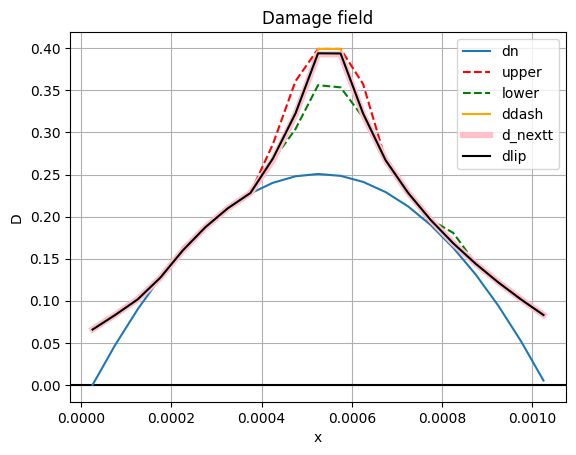

In [7]:
# Plot

def PlotDamage(x, dn, ddash, upper, lower, d_nextt, dlip):
    fig, axes = plt.subplots()
    axes.grid(True, which='both')
    axes.axhline(y=0, color='k')

    plt.title(str("Damage field"))
    plt.xlabel(str("x"))
    plt.ylabel(str("D"))
    plt.plot(x, dn, label='dn')
    plt.plot(x, upper, label='upper', color='red', linestyle = 'dashed')
    plt.plot(x, lower, label='lower', color='green', linestyle = 'dashed')
    plt.plot(x, ddash, label='ddash', color='orange')
    plt.plot(x, d_nextt, label='d_nextt', color='pink', linewidth=4.5)
    plt.plot(x, dlip, label='dlip', color='black')
    plt.legend()
    plt.show()

PlotDamage(x, dn, dp, upper, lower, d_next_all_bar, d_next)